# Previous lessons

## RNNs: LSTM Models

### Load and Prepare Data

In [22]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [23]:
import pandas as pd
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [24]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import custom_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load Data from your path
df = pd.read_csv("Data/yelp-restaurant-reviews-CA-2015-2018.csv.gz", index_col = 'date', parse_dates=['date'])
## Remove any non-english reviews
df = df.loc[ df['language']=='en'].copy()
# Keep only 1,3,5 star reviews
df = df.loc[ df['stars'].isin([1,3,5])]
# Take a smaller subset
df = df.loc['2018']
# Set the index
df = df.set_index('review_id')
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
# Define a filter to identify reviews less than 400 words
filter_short = df['sequence_length']< 400
# Keep short reviews (<400 words)
df=  df.loc[filter_short]
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df_ml,  _ = sampler.fit_resample(df, df['stars'])
df_ml['stars'].value_counts()
# Define X
X = df_ml['text'].values
# Create a map for targets
target_map = {1:0,
              3:1,
              5:2}
# Define y and apply the target_map
y = df_ml['stars'].map(target_map)
# Define classes variable
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

We have filtered the data and defined X and y. These are the same data preparation steps we did in the previous lesson with Bag of Words Models. To review it step by step, please refer to that lesson.

**Convert to Dataset Object**

In [26]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

**Train Test Split**

We will define the train, validation, test ratio as 70/20/10.

We will establish how many samples are required to achieve each percentage. Then we will define a batch size of 32 to determine how many batches are needed. Since we need to round up for the number of batches we will use math.ceil(). We include print statements to clarify the number of samples and batches in each set.

In [27]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	3880 samples 	(122 batches)
    - val:  	1108 samples 	(35 batches)
    - test: 	556 samples 	(18 batches)


Now that we have defined how many samples for each set, we will use the take-and-skip method to separate the data.

In [28]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

We can confirm the length of each set, keeping in mind that this value will be the number of batches.

In [29]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 122 training batches.
 There are 35 validation batches.
 There are 18 testing batches.


### Creating Sequences with the TextVectorization Layer

We can create sequences using the same TextVectorization layer as previous lessons. However, we must use output_mode='int' to create sequences.

**Selecting a Sequence Size**

To ensure that all text sequences have the same length, we will set the output_sequence_length appropriate for our texts. The output will be padded or truncated to this length. The sequence length used can vary depending on a few factors, such as the complexity of your task, the computational resources available, and the architecture of your model. However, here are some general guidelines:
- **Short sequences**: Lengths like 50-100 tokens are relatively short and typically easier to model. They are common in tasks like sentiment analysis.
- **Medium sequences**: 100-500 tokens could be considered medium length. You'll find these in tasks like document classification, summarization, or machine translation of shorter sentences.
- **Long sequences**: 500-1000+ tokens start to be long and can become computationally expensive or challenging for models to handle effectively. You'll find these in tasks like summarizing very long documents or language modeling of entire articles.
- **Very Long sequences**: Lengths above 1000 are usually considered very long and are often difficult to model without specialized techniques like attention mechanisms or model architectures designed for long sequences. These might be used in tasks like genome sequence analysis or extremely detailed document summarization.


**Considerations**
- **Memory**: Longer sequences require exponentially more memory. For example, a sequence length of 800 could require significantly more memory than a sequence length of 400.
- **Computational Time**: Longer sequences usually mean longer training and inference times.
- **Gradient Problems**: Traditional RNNs and LSTMs tend to struggle with very long sequences due to issues like vanishing or exploding gradients. More modern architectures like Transformers or techniques like gradient clipping can help.
- **Quality**: The quality of the model's predictions can decrease for very long sequences if the architecture isn't designed to handle them.
- **Hardware**: If you're running your model on a machine with limited RAM (even with a good GPU), you'll need to be extra cautious with sequence length.

In [30]:
# Define variables for future use
SEQUENCE_LENGTH = 400
EMBED_DIM = 100
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)

Cause: could not parse the source code of <function make_text_vectorization_layer.<locals>.<lambda> at 0x00000195AAD3E0E0>: no matching AST found among candidates:
# coding=utf-8
lambda x, y: x
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function make_text_vectorization_layer.<locals>.<lambda> at 0x00000195AAD3E0E0>: no matching AST found among candidates:
# coding=utf-8
lambda x, y: x
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_3',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 400,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_pun

Remember that our custom function creates the layer and adapts it to the text of the training dataset.

In [31]:
# Check the size of the vocabulary
VOCAB_SIZE = len(sequence_vectorizer.get_vocabulary())
VOCAB_SIZE

13461

Alternatively, we could obtain the size of the vocabulary directly using .vocabulary_size()

In [32]:
# Get the size of the vocabulary
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

13461

### Define and Build an LSTM Model

**Hyperparameters**

1. Recurrent Activation Function: The activation function to use for the recurrent step. Usually, sigmoid is used
2. Return Sequences: Whether to return the last output in the output sequence, or the full sequence. Set this to True if stacking LSTM layers
3. Return State: Whether to return the last state in addition to the output
4. Stateful: If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch
5. Unroll: Whether the network will be unrolled, i.e., whether a fixed-size loop should be used for implementing the recurrent layer. This can speed up computations but might use more memory

We will build the model starting with the pre-trained vectorization layer and the new embedding layer. Note that when we have increased the learning rate for the optimizer to 0.01 from the default of .001.

In [33]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [34]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Now, we will build, fit, and, evaluate the model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 400, 100)          1346100   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,463,735
Trainable params: 1,463,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
122/122 [==============================] - 32s 246ms/step - loss: 1.1020 - accuracy: 0.3168 - val_l

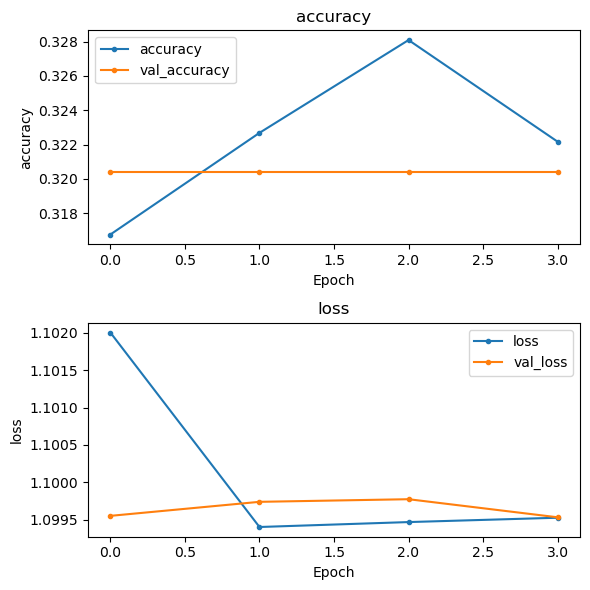


- Evaluating Network...


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1274
           1       0.00      0.00      0.00      1283
           2       0.34      1.00      0.51      1323

    accuracy                           0.34      3880
   macro avg       0.11      0.33      0.17      3880
weighted avg       0.12      0.34      0.17      3880



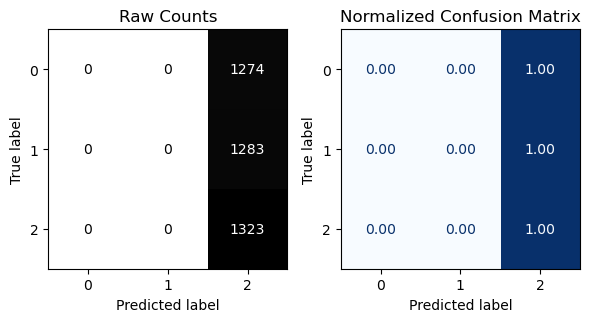


- Evaluating Training Data:
  2/122 [..............................] - ETA: 8s - loss: 1.0970 - accuracy: 0.3906 

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


122/122 [==============================] - 9s 71ms/step - loss: 1.0986 - accuracy: 0.3410
{'loss': 1.0985822677612305, 'accuracy': 0.34097936749458313}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.00      0.00      0.00       191
           2       0.31      1.00      0.47       170

    accuracy                           0.31       556
   macro avg       0.10      0.33      0.16       556
weighted avg       0.09      0.31      0.14       556



C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


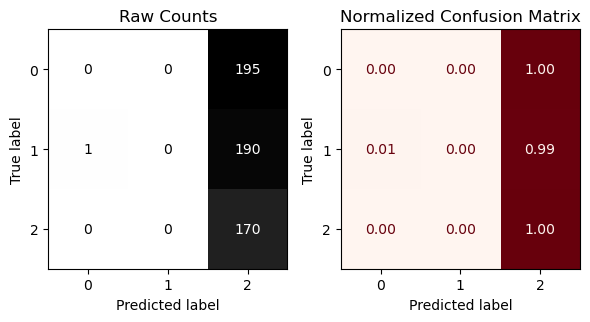


- Evaluating Test Data:
 2/18 [==>...........................] - ETA: 1s - loss: 1.1025 - accuracy: 0.2656

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 [==============================] - 1s 70ms/step - loss: 1.1002 - accuracy: 0.3058
{'loss': 1.1002449989318848, 'accuracy': 0.3057554066181183}


In [35]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

### Summary

This lesson introduced RNNs. After defining and training a text vectorization layer, the next step is designing the embedding layer that will map each integer to a vector that captures the "meaning" of the word. Next, there are several options for the type of RNN layer. We started here with an LSTM layer. The model must conclude with an output layer, as we have seen in previous neural networks. We will explore other types of RNNs in upcoming lessons.

# RNNs: GRUs

**Objective**

- Describe the architecture and functionality of Gated Recurrent Units (GRUs)
- Differentiate between Long Short-Term Memory networks and GRUs
- Build, fit, and evaluate a GRU

### What are GRUs?

Gated Recurrent Units (GRUs) are a type of Recurrent Neural Network (RNN) architecture designed to capture long-term dependencies in sequence data, similar to LSTMs. However, GRUs come with a simpler architecture that combines the forget and update gates into a single "reset" gate, making them computationally more efficient at the cost of some expressive power.

**How do GRUs Work?**

GRUs use a gating mechanism similar to LSTMs but simplified. Each GRU unit has two gates:
1. Reset Gate: Determines how to combine the new input with the previous memory
2. Update Gate: Decides what information to store and what to discard from the state.

These gates allow the GRU to decide what information is relevant to keep or discard while processing sequences, thus enabling it to capture long-term dependencies in the data.

**GRUs vs LSTMs**
1. Simplicity: GRUs have a simpler architecture compared to LSTMs. They use fewer gates and have fewer parameters, making them quicker to train.
2. Computational Efficiency: Due to their simplicity, GRUs are generally more computationally efficient than LSTMs, which might be desirable for tasks with less computational resources or for simpler NLP tasks.
3. Performance: While LSTMs tend to perform slightly better on more complex tasks due to their additional complexity, GRUs often achieve similar performance with quicker training times for certain tasks.
4. Memory Requirement: GRUs are often more memory-efficient because of their reduced complexity, which could be a determining factor based on the hardware you are using.

GRUs offer a simplified, computationally efficient alternative to LSTMs for sequence-based tasks in NLP. While they may lack some of the expressive power of LSTMs, their faster training times and lower computational requirements make them a worthy consideration for many NLP applications.

### Building a GRU

As with the LSTM model, we must start a pre-trained sequence vectorization layer and an embedding layer. First, we will confirm the values we have saved for use in our embedding layer.

In [36]:
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 13461
 EMBED_DIM: 100
 SEQUENCE_LENGTH: 400


The new layer is the GRU layer. We will set the return_sequences argument to true. We will start with 128 units, but, remember this is a tunable parameter. We will also include a Pooling layer before the output layer.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [38]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 400, 100)          1346100   
                                                                 
 gru (GRU)                   (None, 400, 128)          88320     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,434,807
Trainable params: 1,434,807
No

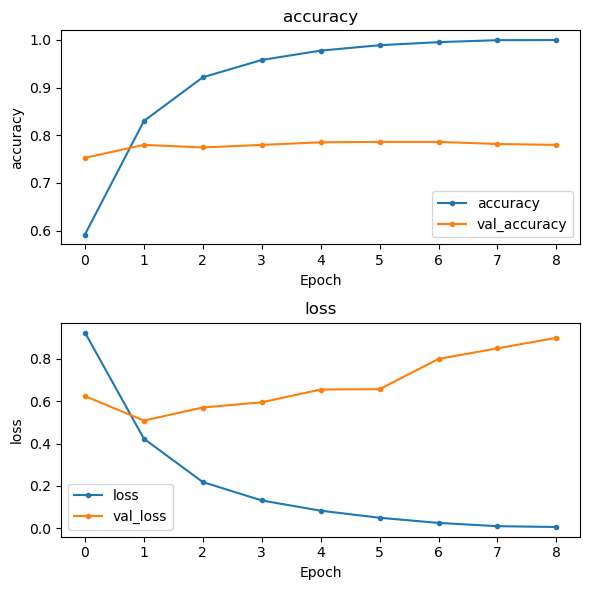


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1274
           1       1.00      1.00      1.00      1283
           2       1.00      1.00      1.00      1323

    accuracy                           1.00      3880
   macro avg       1.00      1.00      1.00      3880
weighted avg       1.00      1.00      1.00      3880



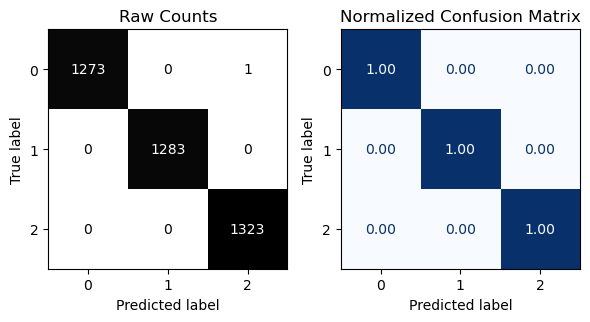


- Evaluating Training Data:
122/122 [==============================] - 7s 56ms/step - loss: 0.0036 - accuracy: 0.9997
{'loss': 0.00364135205745697, 'accuracy': 0.9997422695159912}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       195
           1       0.70      0.77      0.73       191
           2       0.89      0.85      0.87       170

    accuracy                           0.79       556
   macro avg       0.80      0.80      0.80       556
weighted avg       0.80      0.79      0.80       556



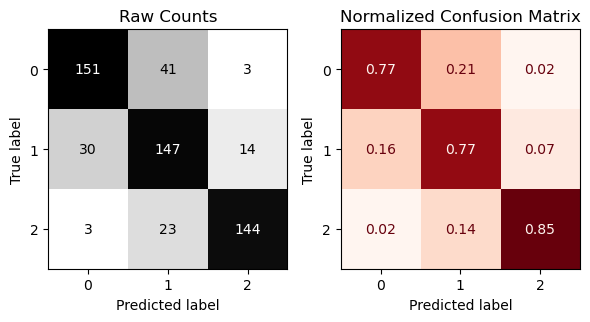


- Evaluating Test Data:
18/18 [==============================] - 1s 55ms/step - loss: 0.8441 - accuracy: 0.7950
{'loss': 0.8441046476364136, 'accuracy': 0.7949640154838562}


In [39]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

### GRU Layer Parameters

The most important parameters for a GRU layer are:
1. Units - This is the dimensionality of the output space. It controls the number of hidden units in the GRU layer. More units can lead to better performance, but it can also increase the risk of overfitting.
2. Activation Function - This is the function that is applied to the output of the GRU layer. The most common activation function for GRU layers is the hyperbolic tangent function (tanh), but other activation functions can also be used.
3. Dropout - This is a technique that is used to prevent overfitting. It works by randomly dropping out some of the units in the GRU layer during training. This forces the model to learn more robust features.

Other important parameters for a GRU layer include:
1. Recurrent activation function - This is the activation function that is applied to the recurrent state of the GRU layer. The most common recurrent activation function for GRU layers is the sigmoid function.
2. Use bias - This is a Boolean parameter that controls whether or not the GRU layer uses a bias vector.
3. Kernel initializer - This is the initializer that is used to initialize the kernel weights of the GRU layer.
4. Recurrent kernel initializer - This initializer is used to initialize the recurrent kernel weights of the GRU layer.
5. Bias constraint - This is a constraint function that is applied to the bias vector of the GRU layer.
6. Return sequences - This is a Boolean parameter that controls whether or not the GRU layer returns the full sequence of outputs or just the last output.
